In [1]:
from ..main import *
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
env = gym.make('MiniGrid-DoorKey-8x8-v0')

In [3]:
def from_pkl_to_rollouts(path):
    twenty_perfect_rollouts = pickle.load(open(path, 'rb'))
    rollouts = [Rollout(obs=rol[0], action=rol[1]) for rol in twenty_perfect_rollouts]
    return rollouts

In [4]:
train_rollouts = from_pkl_to_rollouts('20perfectrollouts.pkl')

In [5]:
train_rollouts

[{'total_reward': 980, 'all': {0: (array([1, 5, 0], dtype=uint8), 0, 0), 1: (array([1, 5, 0], dtype=uint8), 0, 0), 2: (array([7, 5, 0], dtype=uint8), 2, 0), 3: (array([7, 5, 0], dtype=uint8), 2, 0), 4: (array([7, 5, 0], dtype=uint8), 2, 0), 5: (array([7, 5, 0], dtype=uint8), 2, 0), 6: (array([7, 5, 0], dtype=uint8), 2, 0), 7: (array([7, 5, 0], dtype=uint8), 1, 0), 8: (array([4, 5, 0], dtype=uint8), 3, 0), 9: (array([4, 5, 0], dtype=uint8), 1, 0), 10: (array([7, 5, 0], dtype=uint8), 2, 0), 11: (array([4, 5, 0], dtype=uint8), 2, 0), 12: (array([4, 5, 0], dtype=uint8), 1, 0), 13: (array([7, 5, 0], dtype=uint8), 3, 0), 14: (array([7, 5, 1], dtype=uint8), 2, 0), 15: (array([7, 5, 0], dtype=uint8), 2, 0), 16: (array([7, 5, 0], dtype=uint8), 2, 0), 17: (array([7, 5, 0], dtype=uint8), 1, 0), 18: (array([7, 5, 1], dtype=uint8), 2, 0), 19: (array([7, 5, 0], dtype=uint8), 2, 980)}},
 {'total_reward': 982, 'all': {0: (array([7, 5, 0], dtype=uint8), 0, 0), 1: (array([4, 5, 0], dtype=uint8), 2, 0), 

In [6]:
test_rollouts = from_pkl_to_rollouts('20perfectrollouts_2.pkl')

In [7]:
model = Model(
    env.observation_space.spaces['image'].shape,
    env.action_space.n
)
model_cum = Model(
    env.observation_space.spaces['image'].shape,
    env.action_space.n
)

In [8]:
print_freq = {1000: (0, 9, 49, 99, 199, 499, 749, 999),
              100: (0, 9, 24, 49, 74, 99),
              50: (0, 9, 19, 29, 39, 49),
              10: (0, 3, 6, 9)}

In [9]:
def retrain(model, train_set, n_epochs=100, print_stuff=True):
    for i in range(0, n_epochs):
        total_loss = 0
        for r in train_set:
            total_loss += train_model(model, r)
        if print_stuff and i in print_freq[n_epochs]:
            print("loss at epoch {0}: {1}".format(i + 1,
                                                  total_loss / len(train_set)
                                                 ))


In [10]:
curr_seed = 0
def test_on_new(model,
                n_tests=1000,
                eps=0,
                sample=True,
                populate_with_good_rollouts=False):
    global curr_seed
    good_rollouts = []
    n_ok = 0.
    for _ in range(n_tests):
        #different seed = different env
        new_rollout = run_model(model, env,
                                seed=curr_seed,
                                eps=eps,
                                sample=sample)
        n_ok += new_rollout.total_reward > 0
        curr_seed += 1
        if populate_with_good_rollouts and new_rollout.total_reward > 0:
            good_rollouts.append(new_rollout)
    return n_ok/n_tests, good_rollouts

In [11]:
def train_multiple_epochs(n_epochs, train_set, n_tests=200, populate=False,
                          eps=0, print_meta_stuff=True, print_stuff=False, return_train=False):
    successes_sample = []
    successes_argmax = []
    model_sample = Model(
    env.observation_space.spaces['image'].shape,
    env.action_space.n
    )
    cum_train_set_sample = train_set
    cum_train_set_argmax = train_set
    if populate:
        model_argmax = Model(
        env.observation_space.spaces['image'].shape,
        env.action_space.n
        )
    else:
        model_argmax = model_sample
    for k in range(int(n_epochs/50) + 1):
        size_sample = len(cum_train_set_sample)
        size_argmax = len(cum_train_set_argmax)
        succ_sample, good_sample = test_on_new(model_sample, n_tests, eps, True, populate)
        succ_argmax, good_argmax = test_on_new(model_argmax, n_tests, eps, False, populate)
        if populate:
            cum_train_set_sample = np.append(cum_train_set_sample, good_sample)
            cum_train_set_argmax = np.append(cum_train_set_argmax, good_argmax)
        if print_meta_stuff:
            print("succes rate at epoch {0}: (sample (trained on {3} rollouts so far): {1}, argmax (trained on {4} rollouts so far): {2})".format(k*50, succ_sample, succ_argmax, size_sample, size_argmax))
        successes_sample.append(succ_sample)
        successes_argmax.append(succ_argmax)
        if k == int(n_epochs/50):
            break
        retrain(model_sample, cum_train_set_sample, 50, print_stuff=print_stuff)
        if populate:
            retrain(model_argmax, cum_train_set_argmax, 50, print_stuff=print_stuff)
    out_dic = {'successes_sample': successes_sample,
               'successes_argmax': successes_argmax}
    if return_train:
        out_dic['train_sample'] = cum_train_set_sample
        out_dic['train_argmax'] = cum_train_set_argmax
    return out_dic

In [ ]:
per_size_of_train_set_cum = {}
for K in (10, 13, 16, 20, 1, 3, 5):
    per_size_of_train_set_cum[K] = []
    for u in range(5):
        print("--training with {0} elements for the {1}-th time--".format(K, u+1))
        train_set = np.random.choice(train_rollouts, K, False)
        per_size_of_train_set_cum[K].append(train_multiple_epochs(500, train_set, populate=True))
pickle.dump(per_size_of_train_set_cum, open('train_results_cum.pkl', 'wb'))

--training with 13 elements for the 1-th time--
succes rate at epoch 0: (sample (trained on 13 rollouts so far): 0.0, argmax (trained on 13 rollouts so far): 0.0)
succes rate at epoch 50: (sample (trained on 13 rollouts so far): 0.105, argmax (trained on 13 rollouts so far): 0.115)
succes rate at epoch 100: (sample (trained on 34 rollouts so far): 0.34, argmax (trained on 36 rollouts so far): 0.14)


In [137]:
per_size_of_train_set = {}
for K in (1, 3, 5, 10, 13, 16, 20):
    per_size_of_train_set[K] = []
    for u in range(10):
        print("--training with {0} elements for the {1}-th time--".format(K, u+1))
        train_set = np.random.choice(train_rollouts, K, False)
        per_size_of_train_set[K].append(train_multiple_epochs(2000, train_set))
pickle.dump(per_size_of_train_set, open('train_results.pkl', 'wb'))

--training with 1 elements for the 1-th time--
succes rate at epoch 0: (sample: 0.0, argmax: 0.0)
succes rate at epoch 50: (sample: 0.0, argmax: 0.0)
succes rate at epoch 100: (sample: 0.0, argmax: 0.0)
succes rate at epoch 150: (sample: 0.0, argmax: 0.0)
succes rate at epoch 200: (sample: 0.01, argmax: 0.0)
succes rate at epoch 250: (sample: 0.005, argmax: 0.0)
succes rate at epoch 300: (sample: 0.005, argmax: 0.0)
succes rate at epoch 350: (sample: 0.01, argmax: 0.0)
succes rate at epoch 400: (sample: 0.0, argmax: 0.0)
succes rate at epoch 450: (sample: 0.005, argmax: 0.0)
succes rate at epoch 500: (sample: 0.0, argmax: 0.0)
succes rate at epoch 550: (sample: 0.0, argmax: 0.0)
succes rate at epoch 600: (sample: 0.0, argmax: 0.0)
succes rate at epoch 650: (sample: 0.02, argmax: 0.0)
succes rate at epoch 700: (sample: 0.01, argmax: 0.0)
succes rate at epoch 750: (sample: 0.01, argmax: 0.0)
succes rate at epoch 800: (sample: 0.01, argmax: 0.0)
succes rate at epoch 850: (sample: 0.0, arg

succes rate at epoch 1150: (sample: 0.005, argmax: 0.0)
succes rate at epoch 1200: (sample: 0.005, argmax: 0.0)
succes rate at epoch 1250: (sample: 0.005, argmax: 0.0)
succes rate at epoch 1300: (sample: 0.0, argmax: 0.005)
succes rate at epoch 1350: (sample: 0.0, argmax: 0.005)
succes rate at epoch 1400: (sample: 0.0, argmax: 0.0)
succes rate at epoch 1450: (sample: 0.01, argmax: 0.0)
succes rate at epoch 1500: (sample: 0.005, argmax: 0.01)
succes rate at epoch 1550: (sample: 0.0, argmax: 0.0)
succes rate at epoch 1600: (sample: 0.005, argmax: 0.005)
succes rate at epoch 1650: (sample: 0.005, argmax: 0.005)
succes rate at epoch 1700: (sample: 0.0, argmax: 0.0)
succes rate at epoch 1750: (sample: 0.0, argmax: 0.0)
succes rate at epoch 1800: (sample: 0.0, argmax: 0.0)
succes rate at epoch 1850: (sample: 0.0, argmax: 0.0)
succes rate at epoch 1900: (sample: 0.0, argmax: 0.005)
succes rate at epoch 1950: (sample: 0.005, argmax: 0.005)
succes rate at epoch 2000: (sample: 0.0, argmax: 0.0)


succes rate at epoch 250: (sample: 0.0, argmax: 0.0)
succes rate at epoch 300: (sample: 0.01, argmax: 0.0)
succes rate at epoch 350: (sample: 0.005, argmax: 0.0)
succes rate at epoch 400: (sample: 0.0, argmax: 0.0)
succes rate at epoch 450: (sample: 0.005, argmax: 0.0)
succes rate at epoch 500: (sample: 0.01, argmax: 0.0)
succes rate at epoch 550: (sample: 0.005, argmax: 0.0)
succes rate at epoch 600: (sample: 0.0, argmax: 0.0)
succes rate at epoch 650: (sample: 0.0, argmax: 0.0)
succes rate at epoch 700: (sample: 0.005, argmax: 0.0)
succes rate at epoch 750: (sample: 0.0, argmax: 0.005)
succes rate at epoch 800: (sample: 0.0, argmax: 0.0)
succes rate at epoch 850: (sample: 0.005, argmax: 0.0)
succes rate at epoch 900: (sample: 0.0, argmax: 0.0)
succes rate at epoch 950: (sample: 0.0, argmax: 0.0)
succes rate at epoch 1000: (sample: 0.0, argmax: 0.0)
succes rate at epoch 1050: (sample: 0.0, argmax: 0.0)
succes rate at epoch 1100: (sample: 0.005, argmax: 0.0)
succes rate at epoch 1150: 

succes rate at epoch 1350: (sample: 0.05, argmax: 0.035)
succes rate at epoch 1400: (sample: 0.035, argmax: 0.04)
succes rate at epoch 1450: (sample: 0.055, argmax: 0.015)
succes rate at epoch 1500: (sample: 0.03, argmax: 0.02)
succes rate at epoch 1550: (sample: 0.025, argmax: 0.04)
succes rate at epoch 1600: (sample: 0.035, argmax: 0.02)
succes rate at epoch 1650: (sample: 0.04, argmax: 0.025)
succes rate at epoch 1700: (sample: 0.045, argmax: 0.02)
succes rate at epoch 1750: (sample: 0.04, argmax: 0.02)
succes rate at epoch 1800: (sample: 0.055, argmax: 0.03)
succes rate at epoch 1850: (sample: 0.045, argmax: 0.025)
succes rate at epoch 1900: (sample: 0.02, argmax: 0.025)
succes rate at epoch 1950: (sample: 0.045, argmax: 0.04)
succes rate at epoch 2000: (sample: 0.03, argmax: 0.025)
--training with 3 elements for the 2-th time--
succes rate at epoch 0: (sample: 0.0, argmax: 0.0)
succes rate at epoch 50: (sample: 0.0, argmax: 0.0)
succes rate at epoch 100: (sample: 0.03, argmax: 0.0

succes rate at epoch 300: (sample: 0.085, argmax: 0.03)
succes rate at epoch 350: (sample: 0.075, argmax: 0.07)
succes rate at epoch 400: (sample: 0.075, argmax: 0.07)
succes rate at epoch 450: (sample: 0.065, argmax: 0.045)
succes rate at epoch 500: (sample: 0.105, argmax: 0.025)
succes rate at epoch 550: (sample: 0.08, argmax: 0.055)
succes rate at epoch 600: (sample: 0.07, argmax: 0.065)
succes rate at epoch 650: (sample: 0.085, argmax: 0.04)
succes rate at epoch 700: (sample: 0.11, argmax: 0.045)
succes rate at epoch 750: (sample: 0.105, argmax: 0.05)
succes rate at epoch 800: (sample: 0.085, argmax: 0.055)
succes rate at epoch 850: (sample: 0.095, argmax: 0.06)
succes rate at epoch 900: (sample: 0.075, argmax: 0.055)
succes rate at epoch 950: (sample: 0.085, argmax: 0.035)
succes rate at epoch 1000: (sample: 0.095, argmax: 0.045)
succes rate at epoch 1050: (sample: 0.125, argmax: 0.06)
succes rate at epoch 1100: (sample: 0.09, argmax: 0.08)
succes rate at epoch 1150: (sample: 0.09

succes rate at epoch 1300: (sample: 0.045, argmax: 0.035)
succes rate at epoch 1350: (sample: 0.035, argmax: 0.04)
succes rate at epoch 1400: (sample: 0.035, argmax: 0.04)
succes rate at epoch 1450: (sample: 0.04, argmax: 0.03)
succes rate at epoch 1500: (sample: 0.04, argmax: 0.02)
succes rate at epoch 1550: (sample: 0.035, argmax: 0.025)
succes rate at epoch 1600: (sample: 0.045, argmax: 0.015)
succes rate at epoch 1650: (sample: 0.035, argmax: 0.025)
succes rate at epoch 1700: (sample: 0.01, argmax: 0.02)
succes rate at epoch 1750: (sample: 0.03, argmax: 0.01)
succes rate at epoch 1800: (sample: 0.015, argmax: 0.025)
succes rate at epoch 1850: (sample: 0.05, argmax: 0.015)
succes rate at epoch 1900: (sample: 0.05, argmax: 0.005)
succes rate at epoch 1950: (sample: 0.035, argmax: 0.03)
succes rate at epoch 2000: (sample: 0.045, argmax: 0.01)
--training with 3 elements for the 9-th time--
succes rate at epoch 0: (sample: 0.0, argmax: 0.0)
succes rate at epoch 50: (sample: 0.01, argmax

succes rate at epoch 300: (sample: 0.09, argmax: 0.075)
succes rate at epoch 350: (sample: 0.14, argmax: 0.08)
succes rate at epoch 400: (sample: 0.1, argmax: 0.065)
succes rate at epoch 450: (sample: 0.1, argmax: 0.04)
succes rate at epoch 500: (sample: 0.155, argmax: 0.08)
succes rate at epoch 550: (sample: 0.125, argmax: 0.05)
succes rate at epoch 600: (sample: 0.11, argmax: 0.05)
succes rate at epoch 650: (sample: 0.135, argmax: 0.06)
succes rate at epoch 700: (sample: 0.16, argmax: 0.075)
succes rate at epoch 750: (sample: 0.145, argmax: 0.065)
succes rate at epoch 800: (sample: 0.145, argmax: 0.09)
succes rate at epoch 850: (sample: 0.13, argmax: 0.075)
succes rate at epoch 900: (sample: 0.115, argmax: 0.04)
succes rate at epoch 950: (sample: 0.16, argmax: 0.055)
succes rate at epoch 1000: (sample: 0.15, argmax: 0.045)
succes rate at epoch 1050: (sample: 0.19, argmax: 0.07)
succes rate at epoch 1100: (sample: 0.115, argmax: 0.06)
succes rate at epoch 1150: (sample: 0.095, argmax:

succes rate at epoch 1350: (sample: 0.075, argmax: 0.015)
succes rate at epoch 1400: (sample: 0.07, argmax: 0.04)
succes rate at epoch 1450: (sample: 0.065, argmax: 0.06)
succes rate at epoch 1500: (sample: 0.075, argmax: 0.035)
succes rate at epoch 1550: (sample: 0.08, argmax: 0.04)
succes rate at epoch 1600: (sample: 0.09, argmax: 0.05)
succes rate at epoch 1650: (sample: 0.07, argmax: 0.035)
succes rate at epoch 1700: (sample: 0.055, argmax: 0.03)
succes rate at epoch 1750: (sample: 0.11, argmax: 0.045)
succes rate at epoch 1800: (sample: 0.06, argmax: 0.07)
succes rate at epoch 1850: (sample: 0.1, argmax: 0.025)
succes rate at epoch 1900: (sample: 0.09, argmax: 0.055)
succes rate at epoch 1950: (sample: 0.075, argmax: 0.03)
succes rate at epoch 2000: (sample: 0.08, argmax: 0.065)
--training with 5 elements for the 6-th time--
succes rate at epoch 0: (sample: 0.0, argmax: 0.0)
succes rate at epoch 50: (sample: 0.0, argmax: 0.0)
succes rate at epoch 100: (sample: 0.02, argmax: 0.005)

succes rate at epoch 300: (sample: 0.095, argmax: 0.055)
succes rate at epoch 350: (sample: 0.055, argmax: 0.04)
succes rate at epoch 400: (sample: 0.07, argmax: 0.025)
succes rate at epoch 450: (sample: 0.055, argmax: 0.035)
succes rate at epoch 500: (sample: 0.05, argmax: 0.06)
succes rate at epoch 550: (sample: 0.065, argmax: 0.03)
succes rate at epoch 600: (sample: 0.05, argmax: 0.025)
succes rate at epoch 650: (sample: 0.105, argmax: 0.035)
succes rate at epoch 700: (sample: 0.065, argmax: 0.03)
succes rate at epoch 750: (sample: 0.145, argmax: 0.025)
succes rate at epoch 800: (sample: 0.095, argmax: 0.05)
succes rate at epoch 850: (sample: 0.09, argmax: 0.04)
succes rate at epoch 900: (sample: 0.095, argmax: 0.025)
succes rate at epoch 950: (sample: 0.055, argmax: 0.02)
succes rate at epoch 1000: (sample: 0.075, argmax: 0.025)
succes rate at epoch 1050: (sample: 0.07, argmax: 0.05)
succes rate at epoch 1100: (sample: 0.07, argmax: 0.015)
succes rate at epoch 1150: (sample: 0.11, 

succes rate at epoch 1300: (sample: 0.305, argmax: 0.21)
succes rate at epoch 1350: (sample: 0.29, argmax: 0.24)
succes rate at epoch 1400: (sample: 0.26, argmax: 0.23)
succes rate at epoch 1450: (sample: 0.27, argmax: 0.195)
succes rate at epoch 1500: (sample: 0.195, argmax: 0.225)
succes rate at epoch 1550: (sample: 0.24, argmax: 0.215)
succes rate at epoch 1600: (sample: 0.22, argmax: 0.21)
succes rate at epoch 1650: (sample: 0.28, argmax: 0.175)
succes rate at epoch 1700: (sample: 0.24, argmax: 0.18)
succes rate at epoch 1750: (sample: 0.205, argmax: 0.16)
succes rate at epoch 1800: (sample: 0.29, argmax: 0.27)
succes rate at epoch 1850: (sample: 0.255, argmax: 0.175)
succes rate at epoch 1900: (sample: 0.32, argmax: 0.235)
succes rate at epoch 1950: (sample: 0.27, argmax: 0.25)
succes rate at epoch 2000: (sample: 0.26, argmax: 0.215)
--training with 10 elements for the 3-th time--
succes rate at epoch 0: (sample: 0.0, argmax: 0.0)
succes rate at epoch 50: (sample: 0.075, argmax: 0

succes rate at epoch 250: (sample: 0.175, argmax: 0.09)
succes rate at epoch 300: (sample: 0.085, argmax: 0.01)
succes rate at epoch 350: (sample: 0.12, argmax: 0.085)
succes rate at epoch 400: (sample: 0.195, argmax: 0.145)
succes rate at epoch 450: (sample: 0.175, argmax: 0.13)
succes rate at epoch 500: (sample: 0.21, argmax: 0.165)
succes rate at epoch 550: (sample: 0.175, argmax: 0.135)
succes rate at epoch 600: (sample: 0.145, argmax: 0.15)
succes rate at epoch 650: (sample: 0.14, argmax: 0.135)
succes rate at epoch 700: (sample: 0.23, argmax: 0.13)
succes rate at epoch 750: (sample: 0.18, argmax: 0.155)
succes rate at epoch 800: (sample: 0.18, argmax: 0.125)
succes rate at epoch 850: (sample: 0.23, argmax: 0.15)
succes rate at epoch 900: (sample: 0.14, argmax: 0.16)
succes rate at epoch 950: (sample: 0.17, argmax: 0.16)
succes rate at epoch 1000: (sample: 0.215, argmax: 0.135)
succes rate at epoch 1050: (sample: 0.18, argmax: 0.185)
succes rate at epoch 1100: (sample: 0.145, argm

succes rate at epoch 1300: (sample: 0.135, argmax: 0.105)
succes rate at epoch 1350: (sample: 0.125, argmax: 0.125)
succes rate at epoch 1400: (sample: 0.16, argmax: 0.115)
succes rate at epoch 1450: (sample: 0.15, argmax: 0.12)
succes rate at epoch 1500: (sample: 0.16, argmax: 0.09)
succes rate at epoch 1550: (sample: 0.105, argmax: 0.08)
succes rate at epoch 1600: (sample: 0.12, argmax: 0.07)
succes rate at epoch 1650: (sample: 0.115, argmax: 0.06)
succes rate at epoch 1700: (sample: 0.105, argmax: 0.09)
succes rate at epoch 1750: (sample: 0.095, argmax: 0.07)
succes rate at epoch 1800: (sample: 0.12, argmax: 0.095)
succes rate at epoch 1850: (sample: 0.155, argmax: 0.045)
succes rate at epoch 1900: (sample: 0.145, argmax: 0.065)
succes rate at epoch 1950: (sample: 0.155, argmax: 0.09)
succes rate at epoch 2000: (sample: 0.18, argmax: 0.07)
--training with 10 elements for the 10-th time--
succes rate at epoch 0: (sample: 0.0, argmax: 0.0)
succes rate at epoch 50: (sample: 0.06, argma

succes rate at epoch 200: (sample: 0.17, argmax: 0.12)
succes rate at epoch 250: (sample: 0.23, argmax: 0.115)
succes rate at epoch 300: (sample: 0.235, argmax: 0.16)
succes rate at epoch 350: (sample: 0.195, argmax: 0.205)
succes rate at epoch 400: (sample: 0.215, argmax: 0.21)
succes rate at epoch 450: (sample: 0.185, argmax: 0.16)
succes rate at epoch 500: (sample: 0.255, argmax: 0.2)
succes rate at epoch 550: (sample: 0.21, argmax: 0.22)
succes rate at epoch 600: (sample: 0.175, argmax: 0.205)
succes rate at epoch 650: (sample: 0.205, argmax: 0.125)
succes rate at epoch 700: (sample: 0.135, argmax: 0.1)
succes rate at epoch 750: (sample: 0.115, argmax: 0.105)
succes rate at epoch 800: (sample: 0.15, argmax: 0.11)
succes rate at epoch 850: (sample: 0.165, argmax: 0.115)
succes rate at epoch 900: (sample: 0.195, argmax: 0.08)
succes rate at epoch 950: (sample: 0.215, argmax: 0.175)
succes rate at epoch 1000: (sample: 0.18, argmax: 0.185)
succes rate at epoch 1050: (sample: 0.215, arg

succes rate at epoch 1200: (sample: 0.215, argmax: 0.17)
succes rate at epoch 1250: (sample: 0.23, argmax: 0.17)
succes rate at epoch 1300: (sample: 0.245, argmax: 0.19)
succes rate at epoch 1350: (sample: 0.235, argmax: 0.2)
succes rate at epoch 1400: (sample: 0.245, argmax: 0.185)
succes rate at epoch 1450: (sample: 0.28, argmax: 0.195)
succes rate at epoch 1500: (sample: 0.26, argmax: 0.185)
succes rate at epoch 1550: (sample: 0.285, argmax: 0.235)
succes rate at epoch 1600: (sample: 0.17, argmax: 0.16)
succes rate at epoch 1650: (sample: 0.24, argmax: 0.175)
succes rate at epoch 1700: (sample: 0.3, argmax: 0.185)
succes rate at epoch 1750: (sample: 0.28, argmax: 0.195)
succes rate at epoch 1800: (sample: 0.275, argmax: 0.165)
succes rate at epoch 1850: (sample: 0.235, argmax: 0.17)
succes rate at epoch 1900: (sample: 0.285, argmax: 0.195)
succes rate at epoch 1950: (sample: 0.23, argmax: 0.29)
succes rate at epoch 2000: (sample: 0.245, argmax: 0.22)
--training with 13 elements for 

succes rate at epoch 150: (sample: 0.24, argmax: 0.245)
succes rate at epoch 200: (sample: 0.335, argmax: 0.26)
succes rate at epoch 250: (sample: 0.335, argmax: 0.22)
succes rate at epoch 300: (sample: 0.215, argmax: 0.2)
succes rate at epoch 350: (sample: 0.215, argmax: 0.165)
succes rate at epoch 400: (sample: 0.175, argmax: 0.14)
succes rate at epoch 450: (sample: 0.185, argmax: 0.165)
succes rate at epoch 500: (sample: 0.285, argmax: 0.165)
succes rate at epoch 550: (sample: 0.3, argmax: 0.195)
succes rate at epoch 600: (sample: 0.225, argmax: 0.17)
succes rate at epoch 650: (sample: 0.295, argmax: 0.205)
succes rate at epoch 700: (sample: 0.31, argmax: 0.25)
succes rate at epoch 750: (sample: 0.25, argmax: 0.235)
succes rate at epoch 800: (sample: 0.325, argmax: 0.26)
succes rate at epoch 850: (sample: 0.29, argmax: 0.205)
succes rate at epoch 900: (sample: 0.26, argmax: 0.26)
succes rate at epoch 950: (sample: 0.275, argmax: 0.24)
succes rate at epoch 1000: (sample: 0.29, argmax

succes rate at epoch 1150: (sample: 0.385, argmax: 0.365)
succes rate at epoch 1200: (sample: 0.38, argmax: 0.305)
succes rate at epoch 1250: (sample: 0.355, argmax: 0.35)
succes rate at epoch 1300: (sample: 0.4, argmax: 0.325)
succes rate at epoch 1350: (sample: 0.39, argmax: 0.315)
succes rate at epoch 1400: (sample: 0.385, argmax: 0.295)
succes rate at epoch 1450: (sample: 0.4, argmax: 0.3)
succes rate at epoch 1500: (sample: 0.43, argmax: 0.345)
succes rate at epoch 1550: (sample: 0.41, argmax: 0.33)
succes rate at epoch 1600: (sample: 0.41, argmax: 0.29)
succes rate at epoch 1650: (sample: 0.405, argmax: 0.32)
succes rate at epoch 1700: (sample: 0.41, argmax: 0.355)
succes rate at epoch 1750: (sample: 0.38, argmax: 0.325)
succes rate at epoch 1800: (sample: 0.41, argmax: 0.33)
succes rate at epoch 1850: (sample: 0.385, argmax: 0.305)
succes rate at epoch 1900: (sample: 0.39, argmax: 0.385)
succes rate at epoch 1950: (sample: 0.4, argmax: 0.34)
succes rate at epoch 2000: (sample: 0

succes rate at epoch 100: (sample: 0.25, argmax: 0.22)
succes rate at epoch 150: (sample: 0.33, argmax: 0.215)
succes rate at epoch 200: (sample: 0.28, argmax: 0.195)
succes rate at epoch 250: (sample: 0.24, argmax: 0.21)
succes rate at epoch 300: (sample: 0.265, argmax: 0.17)
succes rate at epoch 350: (sample: 0.245, argmax: 0.2)
succes rate at epoch 400: (sample: 0.265, argmax: 0.22)
succes rate at epoch 450: (sample: 0.235, argmax: 0.195)
succes rate at epoch 500: (sample: 0.28, argmax: 0.21)
succes rate at epoch 550: (sample: 0.25, argmax: 0.16)
succes rate at epoch 600: (sample: 0.21, argmax: 0.15)
succes rate at epoch 650: (sample: 0.24, argmax: 0.165)
succes rate at epoch 700: (sample: 0.26, argmax: 0.165)
succes rate at epoch 750: (sample: 0.29, argmax: 0.195)
succes rate at epoch 800: (sample: 0.21, argmax: 0.19)
succes rate at epoch 850: (sample: 0.25, argmax: 0.16)
succes rate at epoch 900: (sample: 0.27, argmax: 0.165)
succes rate at epoch 950: (sample: 0.29, argmax: 0.18)


succes rate at epoch 1150: (sample: 0.43, argmax: 0.305)
succes rate at epoch 1200: (sample: 0.465, argmax: 0.35)
succes rate at epoch 1250: (sample: 0.44, argmax: 0.33)
succes rate at epoch 1300: (sample: 0.435, argmax: 0.405)
succes rate at epoch 1350: (sample: 0.435, argmax: 0.35)
succes rate at epoch 1400: (sample: 0.455, argmax: 0.385)
succes rate at epoch 1450: (sample: 0.45, argmax: 0.41)
succes rate at epoch 1500: (sample: 0.455, argmax: 0.355)
succes rate at epoch 1550: (sample: 0.475, argmax: 0.3)
succes rate at epoch 1600: (sample: 0.355, argmax: 0.375)
succes rate at epoch 1650: (sample: 0.475, argmax: 0.35)
succes rate at epoch 1700: (sample: 0.43, argmax: 0.375)
succes rate at epoch 1750: (sample: 0.445, argmax: 0.435)
succes rate at epoch 1800: (sample: 0.405, argmax: 0.385)
succes rate at epoch 1850: (sample: 0.45, argmax: 0.41)
succes rate at epoch 1900: (sample: 0.4, argmax: 0.415)
succes rate at epoch 1950: (sample: 0.37, argmax: 0.35)
succes rate at epoch 2000: (sam

succes rate at epoch 50: (sample: 0.2, argmax: 0.135)
succes rate at epoch 100: (sample: 0.41, argmax: 0.31)
succes rate at epoch 150: (sample: 0.435, argmax: 0.345)
succes rate at epoch 200: (sample: 0.46, argmax: 0.39)
succes rate at epoch 250: (sample: 0.485, argmax: 0.35)
succes rate at epoch 300: (sample: 0.425, argmax: 0.45)
succes rate at epoch 350: (sample: 0.49, argmax: 0.385)
succes rate at epoch 400: (sample: 0.515, argmax: 0.425)
succes rate at epoch 450: (sample: 0.42, argmax: 0.425)
succes rate at epoch 500: (sample: 0.515, argmax: 0.355)
succes rate at epoch 550: (sample: 0.425, argmax: 0.36)
succes rate at epoch 600: (sample: 0.56, argmax: 0.4)
succes rate at epoch 650: (sample: 0.46, argmax: 0.335)
succes rate at epoch 700: (sample: 0.475, argmax: 0.425)
succes rate at epoch 750: (sample: 0.425, argmax: 0.37)
succes rate at epoch 800: (sample: 0.5, argmax: 0.4)
succes rate at epoch 850: (sample: 0.515, argmax: 0.44)
succes rate at epoch 900: (sample: 0.495, argmax: 0.4

succes rate at epoch 1100: (sample: 0.37, argmax: 0.315)
succes rate at epoch 1150: (sample: 0.425, argmax: 0.365)
succes rate at epoch 1200: (sample: 0.43, argmax: 0.405)
succes rate at epoch 1250: (sample: 0.42, argmax: 0.335)
succes rate at epoch 1300: (sample: 0.38, argmax: 0.345)
succes rate at epoch 1350: (sample: 0.375, argmax: 0.365)
succes rate at epoch 1400: (sample: 0.45, argmax: 0.305)
succes rate at epoch 1450: (sample: 0.4, argmax: 0.34)
succes rate at epoch 1500: (sample: 0.43, argmax: 0.395)
succes rate at epoch 1550: (sample: 0.44, argmax: 0.44)
succes rate at epoch 1600: (sample: 0.405, argmax: 0.34)
succes rate at epoch 1650: (sample: 0.46, argmax: 0.345)
succes rate at epoch 1700: (sample: 0.51, argmax: 0.415)
succes rate at epoch 1750: (sample: 0.375, argmax: 0.39)
succes rate at epoch 1800: (sample: 0.38, argmax: 0.365)
succes rate at epoch 1850: (sample: 0.415, argmax: 0.335)
succes rate at epoch 1900: (sample: 0.405, argmax: 0.305)
succes rate at epoch 1950: (sa

In [21]:
train_rollouts = pickle.load(open('train_results.pkl', 'rb'))
train_rollouts_cum = pickle.load(open('train_results_cum.pkl', 'rb'))

In [40]:
means_sample = lambda train_rollouts, K: [np.mean([train_rollouts[K][i]['successes_sample'][k] for i in range(len(train_rollouts[K]))]) for k in range(len(train_rollouts[K][0]['successes_sample']))]
std_sample = lambda train_rollouts, K: [np.std([train_rollouts[K][i]['successes_sample'][k] for i in range(len(train_rollouts[K]))]) for k in range(len(train_rollouts[K][0]['successes_sample']))]
range_sample = lambda train_rollouts, K: [np.max([train_rollouts[K][i]['successes_sample'][k] for i in range(len(train_rollouts[K]))]) - np.min([train_rollouts[K][i]['successes_sample'][k] for i in range(len(train_rollouts[K]))]) for k in range(len(train_rollouts[K][0]['successes_sample']))]
means_argmax = lambda train_rollouts, K: [np.mean([train_rollouts[K][i]['successes_argmax'][k] for i in range(len(train_rollouts[K]))]) for k in range(len(train_rollouts[K][0]['successes_argmax']))]
std_argmax = lambda train_rollouts, K: [np.std([train_rollouts[K][i]['successes_argmax'][k] for i in range(len(train_rollouts[K]))]) for k in range(len(train_rollouts[K][0]['successes_argmax']))]
range_argmax = lambda train_rollouts, K: [np.max([train_rollouts[K][i]['successes_argmax'][k] for i in range(len(train_rollouts[K]))]) - np.min([train_rollouts[K][i]['successes_argmax'][k] for i in range(len(train_rollouts[K]))]) for k in range(len(train_rollouts[K][0]['successes_argmax']))]

In [41]:
def plot_stuff(ax, train_rollouts, train_set_size):
    #ax.rcParams['figure.figsize'] = (6, 3)
    K = train_set_size
    i = 0
    ax.errorbar(50 * np.arange(len(train_rollouts[K][i]['successes_sample'])),
                means_sample(train_rollouts, train_set_size),
                .5 * np.array(range_sample(train_rollouts, train_set_size)),
                label='with sampling')
    ax.errorbar(50 * np.arange(len(train_rollouts[K][i]['successes_argmax'])),
                means_argmax(train_rollouts, train_set_size),
                .5 * np.array(range_argmax(train_rollouts, train_set_size)),
                label='with argmax')
    ax.set_title('With a train set size of {0}'.format(train_set_size))
    ax.legend()

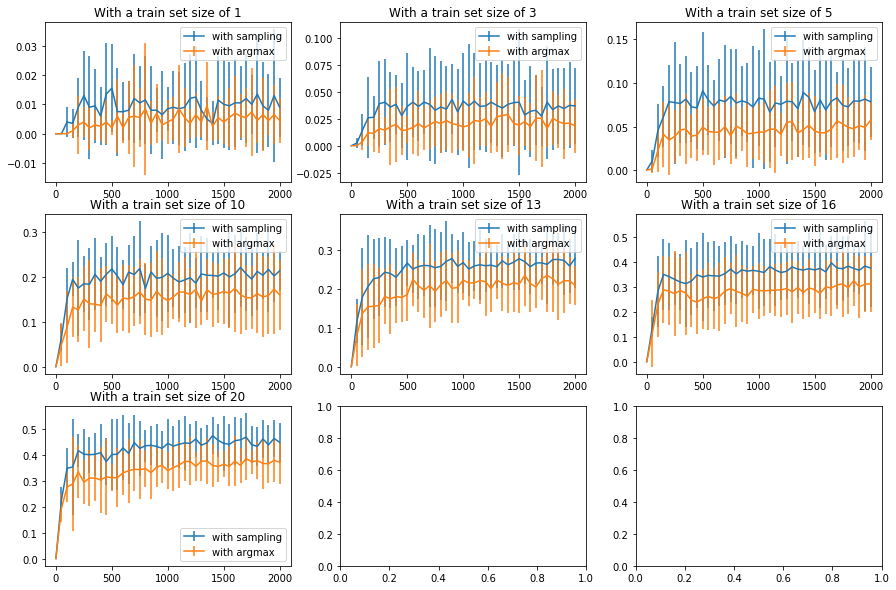

In [42]:
plt.rcParams['figure.figsize'] = (15, 10)
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols)
for i in range(len(train_rollouts.keys())):
    plot_stuff(axes[int(i/n_cols), i%n_cols], train_rollouts, list(train_rollouts.keys())[i])

In [37]:
train_rollouts_cum[13]

[{'successes_argmax': [0.0,
   0.115,
   0.14,
   0.135,
   0.205,
   0.22,
   0.28,
   0.26,
   0.275,
   0.32,
   0.38],
  'successes_sample': [0.0,
   0.105,
   0.34,
   0.31,
   0.395,
   0.48,
   0.645,
   0.535,
   0.57,
   0.575,
   0.585]},
 {'successes_argmax': [0.0,
   0.125,
   0.21,
   0.38,
   0.465,
   0.505,
   0.54,
   0.575,
   0.625,
   0.67,
   0.595],
  'successes_sample': [0.0,
   0.19,
   0.345,
   0.38,
   0.445,
   0.54,
   0.635,
   0.655,
   0.675,
   0.72,
   0.675]},
 {'successes_argmax': [0.0,
   0.055,
   0.04,
   0.09,
   0.1,
   0.105,
   0.145,
   0.125,
   0.165,
   0.22,
   0.195],
  'successes_sample': [0.0,
   0.075,
   0.12,
   0.2,
   0.245,
   0.48,
   0.395,
   0.455,
   0.47,
   0.615,
   0.625]},
 {'successes_argmax': [0.0,
   0.04,
   0.19,
   0.135,
   0.19,
   0.305,
   0.255,
   0.405,
   0.48,
   0.405,
   0.465],
  'successes_sample': [0.0,
   0.17,
   0.14,
   0.345,
   0.405,
   0.53,
   0.605,
   0.645,
   0.705,
   0.64,
   0.655]},


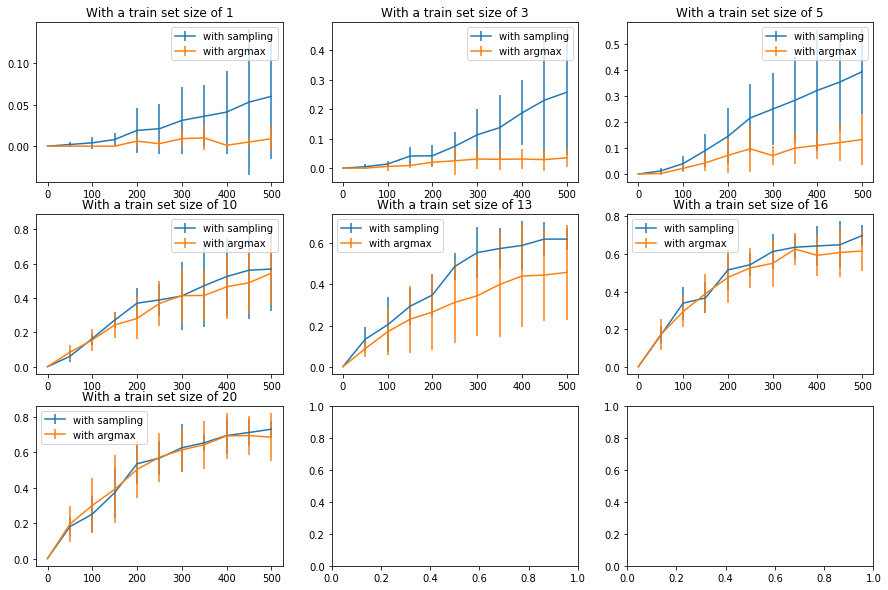

In [44]:
plt.rcParams['figure.figsize'] = (15, 10)
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols)
for i in range(len(train_rollouts.keys())):
    plot_stuff(axes[int(i/n_cols), i%n_cols], train_rollouts_cum, list(train_rollouts.keys())[i])

In [65]:
def get_accuracy(model, rollouts):
    accuracy_per_rollout = []
    for rollout in rollouts:
        actions_predicted = []
        for i in range(len(rollout.obs)):
            _, argm = torch.max(model.forward(rollout.obs[i]), 1)
            actions_predicted.append(argm.data[0])
        accuracy_per_rollout.append((np.array(actions_predicted)==rollout.action).mean())
    return accuracy_per_rollout
#train_accuracy = get_accuracy(model, train_rollouts)
#test_accuracy = get_accuracy(model, test_rollouts)
#print(np.mean(train_accuracy))
#print(np.mean(test_accuracy))

0.7825198741317163
0.7461610072504035
